In [284]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy, time
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics

data_path = 'data/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')

train_Y = df_train['poi'].astype('int')
ids = df_test['name']
df_train = df_train.drop(['name', 'poi','email_address'] , axis=1)
df_test = df_test.drop(['name','email_address'] , axis=1)
df = pd.concat([df_train, df_test])
df.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [285]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_this_person_to_poi,41.095890
from_poi_to_this_person,41.095890
from_messages,41.095890


In [286]:
df_train2 = pd.read_csv(data_path + 'train_data.csv')
df2 = df_train2.drop(['name','email_address'] , axis=1)
df2.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


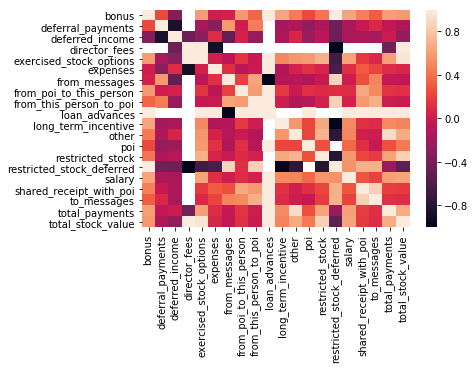

In [287]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df2.corr()
sns.heatmap(corr)
plt.show()

In [288]:
# 篩選相關係數大於 0.1 或小於 -0.1 的特徵
high_list = list(corr[(corr['poi']>0.1) | (corr['poi']<-0.1)].index)
high_list.remove('poi')
high_list.remove('deferral_payments')
high_list.remove('deferred_income')
print(high_list)

['bonus', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'total_payments', 'total_stock_value']


In [289]:
df = df[high_list]
df.head()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,loan_advances,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,total_stock_value
0,1750000.0,19794175.0,46950.0,18.0,42.0,NaN,1617011.0,174839.0,2748364.0,420636.0,864.0,505050.0,22542539.0
1,5600000.0,19250000.0,29336.0,108.0,88.0,NaN,1920000.0,22122.0,6843672.0,1111258.0,2042.0,8682716.0,26093672.0
2,200000.0,1624396.0,22884.0,39.0,13.0,NaN,NaN,1573324.0,869220.0,211844.0,91.0,2003885.0,2493616.0
3,800000.0,NaN,118134.0,NaN,NaN,NaN,602671.0,907502.0,985032.0,224305.0,NaN,2652612.0,985032.0
4,1250000.0,NaN,35818.0,144.0,199.0,NaN,375304.0,486.0,126027.0,240189.0,2188.0,1639297.0,126027.0


In [290]:
# 部分欄位缺值填補 0
zero_cols = ['bonus', 'exercised_stock_options', 'expenses', 'from_messages', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'total_payments', 'total_stock_value']
for col in zero_cols:
    df[col] = df[col].fillna(0)
    
# 部分欄位缺值填補 mean
mean_cols = ['from_poi_to_this_person']
for col in mean_cols:
    df[col] = df[col].fillna(df[col].mean())

In [291]:
na_check(df)

,Missing Ratio


In [292]:
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

In [293]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestRegressor()
estimator.fit(train_X.values, train_Y)
# estimator.feature_importances_ 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

exercised_stock_options    0.171346
expenses                   0.156718
bonus                      0.153274
other                      0.136820
total_stock_value          0.124670
salary                     0.068336
shared_receipt_with_poi    0.061892
long_term_incentive        0.054894
from_messages              0.030825
restricted_stock           0.020792
from_poi_to_this_person    0.010363
total_payments             0.010071
loan_advances              0.000000
dtype: float64

In [294]:
df = pd.concat([train_X, test_X])
high_feature = list(feats[:10].index)
df = df[high_feature]

In [295]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

In [296]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=42)

# 建立模型
clf = GradientBoostingRegressor(random_state=7)

# 先看看使用預設參數得到的結果，約為 8.379 的 MSE
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(metrics.mean_squared_error(y_test, y_pred))

0.08631171807181977


In [297]:
# 設定要訓練的超參數組合
n_estimators = [100, 150, 200, 250, 300]
max_depth = [1, 2, 3, 4, 5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(clf, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished


In [298]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: -0.092562 using {'max_depth': 1, 'n_estimators': 100}


In [299]:
# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
lr = LogisticRegression()
gdbt = GradientBoostingClassifier(n_estimators=100, max_depth=1)
rf = RandomForestClassifier()

In [300]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': lr_pred})
sub.to_csv('Enron Fraud_lr.csv', index=False) 

In [301]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': gdbt_pred})
sub.to_csv('Enron Fraud_gdbt.csv', index=False) 

In [302]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': rf_pred})
sub.to_csv('Enron Fraud_rf.csv', index=False) 

In [303]:
# 混合泛化預測檔 
blending_pred = lr_pred*0.3  + gdbt_pred*0.4 + rf_pred*0.3
sub = pd.DataFrame({'name': ids, 'poi': blending_pred})
sub.to_csv('Enron Fraud_blending.csv', index=False)